# OpenVINO Demo: Core API

### Here we will go over basic steps to use OpenVINO's Core API

Begin by loading the required packages/libraries.

In [1]:
# Loading required packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from openvino.inference_engine import IENetwork, IECore
import time

%matplotlib inline

# CHANGE AS NEEDED
OS = 'windows'
dev = 'CPU' # Change to MYRIAD if you have Intel NCS 2 plugged in

# Setting up Core
ie = IECore()

Then we need to load in a network into memory.

In [2]:
path_to_objxml = None
path_to_objbin = None

fp = 'fp32' if dev.lower() == 'cpu' else 'fp16'

if OS.lower() == 'linux':
    path_to_objxml = 'wine_optimized/' + fp + '/frozen_inference_graph.xml'
    path_to_objbin = 'wine_optimized/' + fp + '/frozen_inference_graph.bin'
elif OS.lower() == 'windows':
    path_to_objxml = 'wine_optimized\\' + fp + '\\frozen_inference_graph.xml'
    path_to_objbin = 'wine_optimized\\' + fp + '\\frozen_inference_graph.bin'

obj_net = IENetwork(model=path_to_objxml, weights=path_to_objbin)

Let's do some analysis of the network we have! We essentially only care about the input layers and output layers. Input layers are important because that is where we need to input our data that we receive from our environment. Output layers are important because we need to process whatever comes from there into useful data (classification, confidence, coordinates, etc.)

In [3]:
# Let's look at the layers where the network takes inputs
obj_net.inputs

{'image_tensor': <openvino.inference_engine.ie_api.InputInfo at 0x24ce3220670>}

In [4]:
# Let's look at the layers where the network takes outputs
obj_net.outputs

{'DetectionOutput': <openvino.inference_engine.ie_api.OutputInfo at 0x24cda28f8a0>}

In [5]:
# Let's figure out how to get those input/output layers programmatically
input_layer = next(iter(obj_net.inputs))
output_layer = next(iter(obj_net.outputs))
"Input Layer: " + input_layer, "Output Layer: " + output_layer

('Input Layer: image_tensor', 'Output Layer: DetectionOutput')

Let's focus on the input layer, specifically its *shape*. The shape determines what kind of input that the network expects.

In [6]:
n, c, h, w = obj_net.inputs[input_layer].shape
n, c, h, w

(1, 3, 300, 300)

Based on our analysis of the network, our network expects **n=1 images** with **c=3 channels** and has a **h=300 height** and a **w=300 width**. For clarification, channels refers to the RGB or Red Green Blue channels that define an image. We think of digital pictures as a collection of pixels, where each pixel has a color defined by (R, G, B). 

Now that we have this information, we must pre-process our input data in order to fit the requirements of the network. Let's first look at our image.

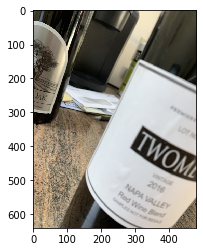

In [7]:
obj_frame = cv2.imread('wine_test_images/IMG_1463.JPG')
plt.imshow(cv2.cvtColor(obj_frame, cv2.COLOR_BGR2RGB))

Now, let's preprocess our data! There is this one confusing step where we need to flip the channels from RGB to BGR. This is because when users are instructed to do model optimization, they are often told to enter the tag `--reverse_input_channels` when running configuring the model optimizer script.

In [8]:
# resize image
obj_in_frame = cv2.resize(obj_frame, (w, h))

# flip channels from HWC to CHW
obj_in_frame = obj_in_frame.transpose((2, 0, 1))

# reshape data into shape network expects
obj_in_frame = obj_in_frame.reshape((n, c, h, w))

The next step we need to take is loading our network into an appropriate plugin. Let's say that we only have a CPU. Then in order to run these type of object detction models, we need to specify an extension for our plugin to use. This just gives our plugin extra abilities like supporting calculations on more layers than usual.

In [9]:
ext = None
if OS.lower() == 'windows':
    ext = 'C:\\Users\\freyes\\Documents\\Intel\\OpenVINO\\inference_engine_samples_build\\intel64\\Release\\cpu_extension.dll'
elif OS.lower() == 'linux':
    ext = '/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so'

# Add extension to Core instead of the IEPlugin
if dev.lower() == 'cpu':
    # Using Core, apply extension to specific device
    ie.add_extension(ext, device_name=dev)
    
# Getting executable network from Core instead of IEPlugin
obj_exec_net = ie.load_network(network=obj_net, device_name=dev, num_requests=1)
obj_exec_net

## Now the moment of inference...

Here we will finally be able to run inference on the data that we have! Just for our interest, we will also print the shape of the output.

In [10]:
obj_res = obj_exec_net.infer({input_layer: obj_in_frame})
obj_det = obj_res[output_layer]
obj_det.shape, obj_frame.shape

((1, 1, 100, 7), (640, 480, 3))

Now we will post-process the data into something useful that we can hold on to. We parse the data via a for-loop. This post-processing script came from sample code that Intel provides to it's developers. The key here is that most people know what the output looks from their model. If we are novice developers, then we can reference Intel's sample code to give us some direction. 

Classification: so_2015 Confidence: 0.97409153
Classification: tm_2016 Confidence: 0.9928875


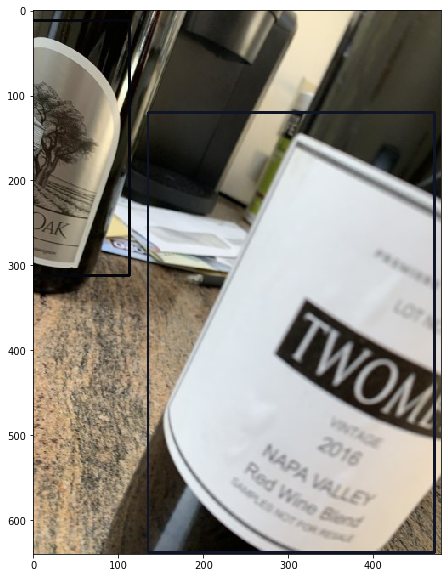

In [11]:
initial_w = obj_frame.shape[1]
initial_h = obj_frame.shape[0]

labels_path = None
if OS.lower() == 'linux':
    labels_path = "wine_optimized/fp16/frozen_inference_graph.labels"
elif OS.lower() == 'windows':
    labels_path = "wine_optimized\\fp16\\frozen_inference_graph.labels"

labels_map = None
if labels_path:
    with open(labels_path, 'r') as f:
        labels_map = [x.strip() for x in f]

for obj in obj_det[0][0]:
    # Draw only objects when probability more than specified threshold
    if obj[2] > 0.5:
        xmin = int(obj[3] * initial_w)
        ymin = int(obj[4] * initial_h)
        xmax = int(obj[5] * initial_w)
        ymax = int(obj[6] * initial_h)
        class_id = int(obj[1]) - 1
        class_string = labels_map[class_id] if labels_map else class_id
        
        # Let's print our classification!
        print("Classification: " + str(class_string), "Confidence: " + str(obj[2]))
        
        # Draw box and label\class_id
        color = (min(class_id * 12.5, 255), min(class_id * 7, 255), min(class_id * 5, 255))
        cv2.rectangle(obj_frame, (xmin, ymin), (xmax, ymax), color, 2)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(obj_frame, cv2.COLOR_BGR2RGB)) 

# Congratuations! 

You now know the developer flow of OpenVINO's Python API!